In [2]:
from src.Distributions import *
from collections import Counter
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines
mpl.rcParams['axes.linewidth'] = 1.4 #set the value globally

In [3]:
alpha_a_v = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
alpha_g_f = 2.0

alpha_a_f = 2.0
alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0]

N = 10**5
dim = [1,2,3,4]

In [ ]:
# Generate .npy with all degree values from gml.gz files
for d in dim:
    for aa in alpha_a_v:
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        degree_file(N, d, aa, alpha_g_f)
    print("-----------------")
    for ag in alpha_g_v:
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")
        degree_file(N, d, alpha_a_f, ag)


N = 100000, dim = 1, alpha_a = 0.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 1.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 3.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 4.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 5.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 6.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 7.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 8.0, alpha_g = 2.0
Folder empty
-----------------
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 1.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 3.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 4.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 5.0
Folder empty
N = 100000, dim = 2, alpha_a = 0.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 2, alpha_a = 1.0, a

In [ ]:
# Generate .npy with all distances values from gml.gz files
for d in dim:
    for aa in alpha_a_v:
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        distance_file(N, d, aa, alpha_g_f)
    
    print("-----------------")
    for ag in alpha_g_v:
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")
        distance_file(N, d, alpha_a_f, ag)

N = 100000, dim = 1, alpha_a = 0.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 1.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 3.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 4.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 5.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 6.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 7.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 8.0, alpha_g = 2.0
Folder empty
-----------------
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 1.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 3.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 4.0
Folder empty
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 5.0
Folder empty
N = 100000, dim = 2, alpha_a = 0.0, alpha_g = 2.0
Folder empty
N = 100000, dim = 2, alpha_a = 1.0, a

In [ ]:
# Generate .npy with all degree values from gml.gz files
bin_count = 40
for d in dim:
    for aa in alpha_a_v:
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_g_f:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_g_f:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="degree")
    
    print("-----------------")
    for ag in alpha_g_v:
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_f:.2f}_alpha_g_{ag:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="distances")
        
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_f:.2f}_alpha_g_{ag:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        log_binning(Counter(dados_flat), bin_count, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="degree")

N = 100000, dim = 1, alpha_a = 0.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_0.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_0.00_alpha_g_2.00/degree_distribution_log.csv
N = 100000, dim = 1, alpha_a = 1.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_1.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_1.00_alpha_g_2.00/degree_distribution_log.csv
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/degree_distribution_log.csv
N = 100000, dim = 1, alpha_a = 3.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_3.00_alpha_g_2.00/distances_distribution_log.csv
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_3.00_alpha_g_2.00/degree_distribution_log.csv
N = 100000, 

In [4]:
# Generate .npy with all degree values from gml.gz files
bin_count = 40
for d in dim:
    for aa in alpha_a_v:
        print(f"N = {N}, dim = {d}, alpha_a = {aa}, alpha_g = {alpha_g_f}")
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_g_f:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=aa, alpha_g=alpha_g_f, propertie="degree")
    
    print("-----------------")
    for ag in alpha_g_v:
        print(f"N = {N}, dim = {d}, alpha_a = {alpha_a_f}, alpha_g = {ag}")    
        dados = np.load(f"../../data/N_{N}/dim_{d}/alpha_a_{alpha_a_f:.2f}_alpha_g_{ag:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
        dados_flat = dados.flatten()
        distribution(dados_flat, save=True, N=N, dim=d, alpha_a=alpha_a_f, alpha_g=ag, propertie="degree")

N = 100000, dim = 1, alpha_a = 0.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_0.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 1.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_1.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 2.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_2.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 3.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_3.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 4.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_4.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 5.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a_5.00_alpha_g_2.00/degree_distribution_linear.csv
N = 100000, dim = 1, alpha_a = 6.0, alpha_g = 2.0
Arquivo salvo em ../../data/N_100000/dim_1/alpha_a

In [3]:
k_1d_g, pk_1d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g, pk_2d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g, pk_3d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g, pk_4d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

In [ ]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/degree_distribution_linear.csv", delimiter=' ')
    
    k_1d_g[i], pk_1d_g[i] = df_1d["k"], df_1d["pk"]
    k_2d_g[i], pk_2d_g[i] = df_2d["k"], df_2d["pk"]
    k_3d_g[i], pk_3d_g[i] = df_3d["k"], df_3d["pk"]
    k_4d_g[i], pk_4d_g[i] = df_4d["k"], df_4d["pk"]

In [5]:
k_1d_a, pk_1d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a, pk_2d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a, pk_3d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a, pk_4d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [6]:
for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/degree_distribution_linear.csv", delimiter=' ')
        
        k_1d_a[i], pk_1d_a[i] = df_1d["k"], df_1d["pk"]
        k_2d_a[i], pk_2d_a[i] = df_2d["k"], df_2d["pk"]
        k_3d_a[i], pk_3d_a[i] = df_3d["k"], df_3d["pk"]
        k_4d_a[i], pk_4d_a[i] = df_4d["k"], df_4d["pk"]

In [156]:
def find_order_of_magnitude(number):
    order = int(math.floor(math.log10(abs(number))))
    return abs(order)    

In [157]:
def normalized_constant(x, q, kappa):
    distribution_list = []
    
    for i in x:
        term = [1 - (1 - q) * ( i / kappa)]**(1 / (1 - q))
        distribution_list.append(term)
    A = 1 / sum(distribution_list)
    
    return A

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from scipy.stats import kstest
import math

def find_order_of_magnitude(number):
    order = int(math.floor(math.log10(abs(number))))
    return abs(order)    

def q(alpha_a,d):
    if(0 <= alpha_a/d <= 1):
        return 4/3
    else:
        return round((1/3)*np.exp(1-alpha_a/d)+1.0,4)

def lambda_(alpha_a,d):
    if(0 <= alpha_a/d <= 1):
        return 0.3
    else:
        return round(-1.15*np.exp(1-alpha_a/d)+1.45,4)
    
def normalized_constant(x, q, b):
    distribution_list = []
    
    for i in range(len(x)):
        term = (1 - (1 - q) * ( x[i] / b ))**(1 / ( 1 - q ) )

        #if not np.isfinite(term):
            #term = 0.0  # or any other value that makes sense in your context
        
        distribution_list.append(term)
    
    A = 1 / sum(distribution_list)
    
    return A

def q_exp(x, q, b):
    A = normalized_constant(x, q, b)
    
    real_distri = []
    for i in range(len(x)):
        term = A * (1 - ( 1 - q ) * ( x[i] / b ) )**(1 / ( 1 - q ))
                # Check for division by zero
        #if not np.isfinite(term):
            #aterm = 0.0  # or any other value that makes sense in your context
            
        real_distri.append(term)

    return real_distri

import numpy as np

# Suponha que k_1d_g[0] e pk_1d_g[0] sejam arrays NumPy
k_1d_g[0] = np.array(k_1d_g[0])
pk_1d_g[0] = np.array(pk_1d_g[0])

# Criar máscara para valores >= 10**(-6)
mask = pk_1d_g[0] >= 10**(-6)

# Aplicar a máscara para manter apenas os valores desejados
k_1d_g_filtered = k_1d_g[0][mask]
pk_1d_g_filtered = pk_1d_g[0][mask]

# k: independent variable, pk: distribution of k
k, pk = k_1d_g_filtered, pk_1d_g_filtered

# Set parameters for the q-exponential distribution (initial parameter)
q_parameter = 1.5
b_parameter = 0.4

# Create a model using the custom q-exponential function (changer with your distribution)
model = Model(q_exp)

# Set initial parameter values
params = model.make_params(q=q_parameter, b=b_parameter)

params['q'].max = 5/3  # Set the maximum bound for q
params['q'].min = 1.01  # Set the maximum bound for q

params['b'].min = 0.03  # Set the minimum bound for b
params['b'].max = 1.45  # Set the maximum bound for b (use np.inf for infinity)


# Fit the model to the truncated data
result = model.fit(pk, params, x=k)

# Get the fitted parameters (best parameters)
fitted_q = result.params['q'].value
fitted_b = result.params['b'].value

#Perform KS test on the fitted q-exponential distribution using the CDF
ks_statistic, ks_p_value = kstest(pk, q_exp(k, fitted_q, fitted_b))
# ks_p_values its similiar to R

[5.70117623e-01 2.08041698e-01 9.61900000e-02 5.01563019e-02
 2.81871321e-02 1.66801887e-02 1.02836981e-02 6.50083019e-03
 4.25830189e-03 2.83803774e-03 1.92520755e-03 1.33550943e-03
 9.40377358e-04 6.70264151e-04 4.83471698e-04 3.47698113e-04
 2.50000000e-04 1.91283019e-04 1.41660377e-04 1.03660377e-04
 7.90188679e-05 6.24528302e-05 4.62641509e-05 3.59245283e-05
 2.98867925e-05 2.18113208e-05 1.79622642e-05 1.29811321e-05
 1.14716981e-05 8.07547170e-06 6.79245283e-06 4.94339623e-06
 3.84905660e-06 3.50943396e-06 2.22641509e-06 2.00000000e-06
 1.50943396e-06 1.24528302e-06 1.09433962e-06 1.05660377e-06]


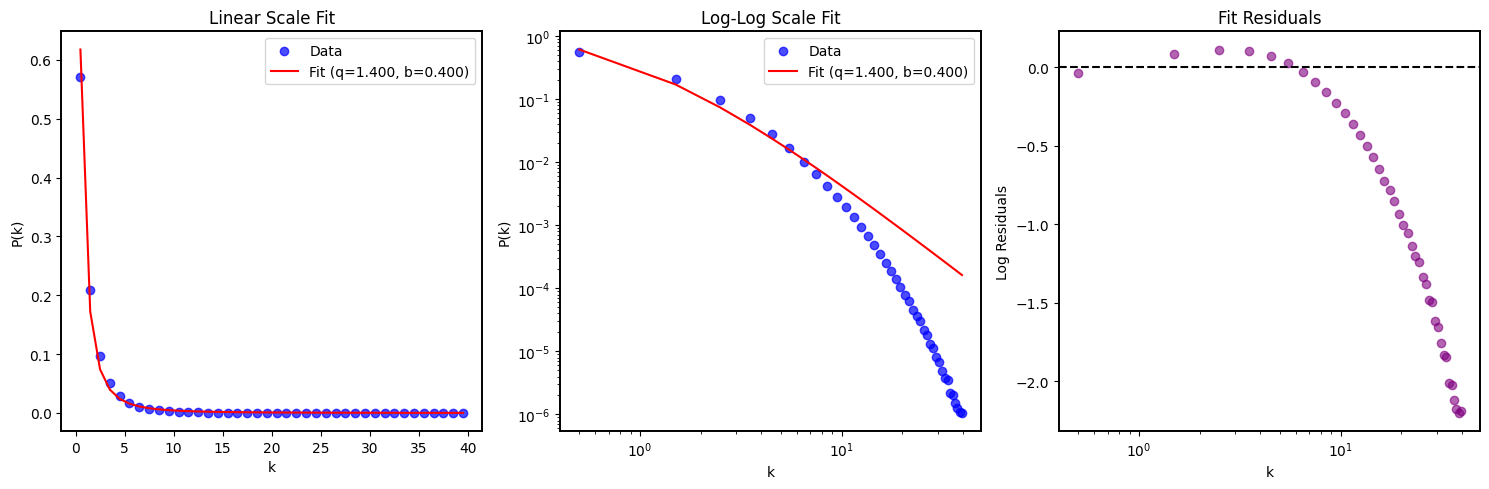

Melhor ajuste: q = 1.40000, b = 0.39999
KS-Test: D = 0.55000, p-value = 0.00001


In [166]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model, minimize
from scipy.stats import kstest
from scipy.optimize import differential_evolution

# Funções do modelo
def normalized_constant(x, q, b):
    distribution_list = (1 - (1 - q) * (x / b)) ** (1 / (1 - q))
    return 1 / np.sum(distribution_list)

def q_exp(x, q, b):
    A = normalized_constant(x, q, b)
    return A * (1 - (1 - q) * (x / b)) ** (1 / (1 - q))

# Dados
k_1d_g[0] = np.array(k_1d_g[0])
pk_1d_g[0] = np.array(pk_1d_g[0])

# Criar máscara para valores >= 10⁻⁶
mask = pk_1d_g[0] >= 10**(-6)
k, pk = k_1d_g[0][mask], pk_1d_g[0][mask]

# ** Log-transform for better fitting in log-scale **
log_k = np.log10(k)
log_pk = np.log10(pk)

# ** Melhor função de pesos para ajuste **
def weight_function(pk):
    return 1 / (np.log10(pk + 1e-8) ** 2 + 1)  # Evita valores extremos

weights = weight_function(pk)

# ** Otimização global antes do ajuste local **
def loss(params):
    q, b = params
    model_pk = np.array(q_exp(k, q, b))
    return np.sum((np.log10(model_pk) - np.log10(pk)) ** 2)

# Otimização global usando Differential Evolution
bounds = [(1.05, 5/3), (0.25, 0.50)]
result_global = differential_evolution(loss, bounds, strategy='best1bin', maxiter=1000, tol=1e-8)
q_best, b_best = result_global.x

# Ajuste refinado usando lmfit
model = Model(q_exp)
params = model.make_params(q=q_best, b=b_best)
params['q'].min, params['q'].max = 1.005, 1.400
params['b'].min, params['b'].max = 0.10, 0.40

result = model.fit(pk, params, x=k, weights=weights)

# Parâmetros finais ajustados
fitted_q = result.params['q'].value
fitted_b = result.params['b'].value

# ** KS-Test para qualidade do fit **
ks_statistic, ks_p_value = kstest(pk, q_exp(k, fitted_q, fitted_b))

# ** Plotagem melhorada **
fig, ax = plt.subplots(1, 3, figsize=(15,5))

# Gráfico Linear
ax[0].scatter(k, pk, label="Data", color="blue", alpha=0.7)
ax[0].plot(k, q_exp(k, fitted_q, fitted_b), label=f"Fit (q={fitted_q:.3f}, b={fitted_b:.3f})", color="red")
ax[0].set_xscale("linear")
ax[0].set_yscale("linear")
ax[0].set_xlabel("k")
ax[0].set_ylabel("P(k)")
ax[0].legend()
ax[0].set_title("Linear Scale Fit")

# Gráfico Log-Log
ax[1].scatter(k, pk, label="Data", color="blue", alpha=0.7)
ax[1].plot(k, q_exp(k, fitted_q, fitted_b), label=f"Fit (q={fitted_q:.3f}, b={fitted_b:.3f})", color="red")
ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel("k")
ax[1].set_ylabel("P(k)")
ax[1].legend()
ax[1].set_title("Log-Log Scale Fit")

# Resíduos
residuals = np.log10(pk) - np.log10(q_exp(k, fitted_q, fitted_b))
ax[2].scatter(k, residuals, color="purple", alpha=0.6)
ax[2].axhline(0, color="black", linestyle="--")
ax[2].set_xscale("log")
ax[2].set_xlabel("k")
ax[2].set_ylabel("Log Residuals")
ax[2].set_title("Fit Residuals")

plt.tight_layout()
plt.show()

# ** Print dos resultados finais **
print(f"Melhor ajuste: q = {fitted_q:.5f}, b = {fitted_b:.5f}")
print(f"KS-Test: D = {ks_statistic:.5f}, p-value = {ks_p_value:.5f}")

In [12]:
def q(alpha_a, d):
    ration = alpha_a/d
    if(0<=ration<=1):
        return 4/3
    else:
        return (1/3)*np.exp(1-ration)+1

def eta(alpha_a, d):
    ration = alpha_a/d
    if(0<=ration<=1):
        return 0.3
    else:
        return -1.15*np.exp(1-ration) + 1.45

# Funções do modelo
def normalized_constant(x, q, b):
    distribution_list = (1 - (1 - q) * (x / b)) ** (1 / (1 - q))
    return 1 / np.sum(distribution_list)

def q_exp(x, q, b):
    A = normalized_constant(x, q, b)
    return A * (1 - (1 - q) * (x / b)) ** (1 / (1 - q))

In [8]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import kstest
from scipy.integrate import quad

def optimize_q_exp(k, pk, q_initial=1.333, b_initial=0.40, delta_q=0.01, delta_b=0.01):
    """
    Otimiza os parâmetros q e b do ajuste q-exponencial dentro de uma faixa restrita.
    
    Parâmetros:
        k (array): Valores de k.
        pk (array): Valores de P(k).
        q_initial (float): Valor inicial de q baseado na relação teórica.
        b_initial (float): Valor inicial de b baseado na relação teórica.
        delta_q (float): Intervalo de variação permitido para q.
        delta_b (float): Intervalo de variação permitido para b.

    Retorna:
        fitted_q (float): Melhor valor ajustado de q.
        fitted_b (float): Melhor valor ajustado de b.
    """
    # Definir a função q-exponencial com normalização segura
    def normalized_constant_safe(q, b, k_vals):
        try:
            integral, _ = quad(lambda x: (1 - (1 - q) * (x / b)) ** (1 / (1 - q)), np.min(k_vals), np.max(k_vals))
            return 1 / integral if integral > 0 else 1
        except:
            return 1

    def q_exp_safe(x, q, b):
        A = normalized_constant_safe(q, b, k)
        return A * (1 - (1 - q) * (x / b)) ** (1 / (1 - q))

    # Ajustar corretamente os limites para garantir valores bem definidos
    bounds_ultra_fine = ([q_initial - delta_q, b_initial - delta_b], [q_initial + delta_q, b_initial + delta_b])

    # Ajuste ultra fino dentro dessa faixa extremamente reduzida
    popt_ultra_fine, _ = curve_fit(q_exp_safe, k, pk, p0=[q_initial, b_initial], bounds=bounds_ultra_fine)

    # Parâmetros finais ajustados
    fitted_q, fitted_b = popt_ultra_fine

    return fitted_q, fitted_b

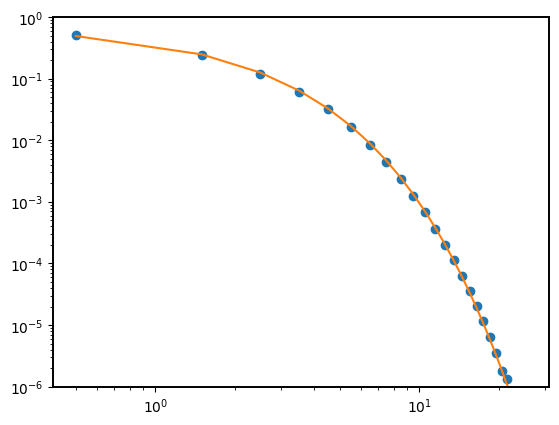

In [13]:
#print(q(alpha_a_v[2],1))

Q, B = optimize_q_exp(k_1d_a[5], pk_1d_a[5], q_initial=q(alpha_a_v[5],1), b_initial=eta(alpha_a_v[5],1), delta_q=0.01, delta_b=0.01)

plt.plot(k_1d_a[5], pk_1d_a[5],'o')
plt.plot(k_1d_a[5], q_exp(k_1d_a[5], Q,B))
plt.xscale("log")
plt.yscale("log")
plt.ylim([10**(-6),1])
plt.savefig("result.pdf")
plt.show()


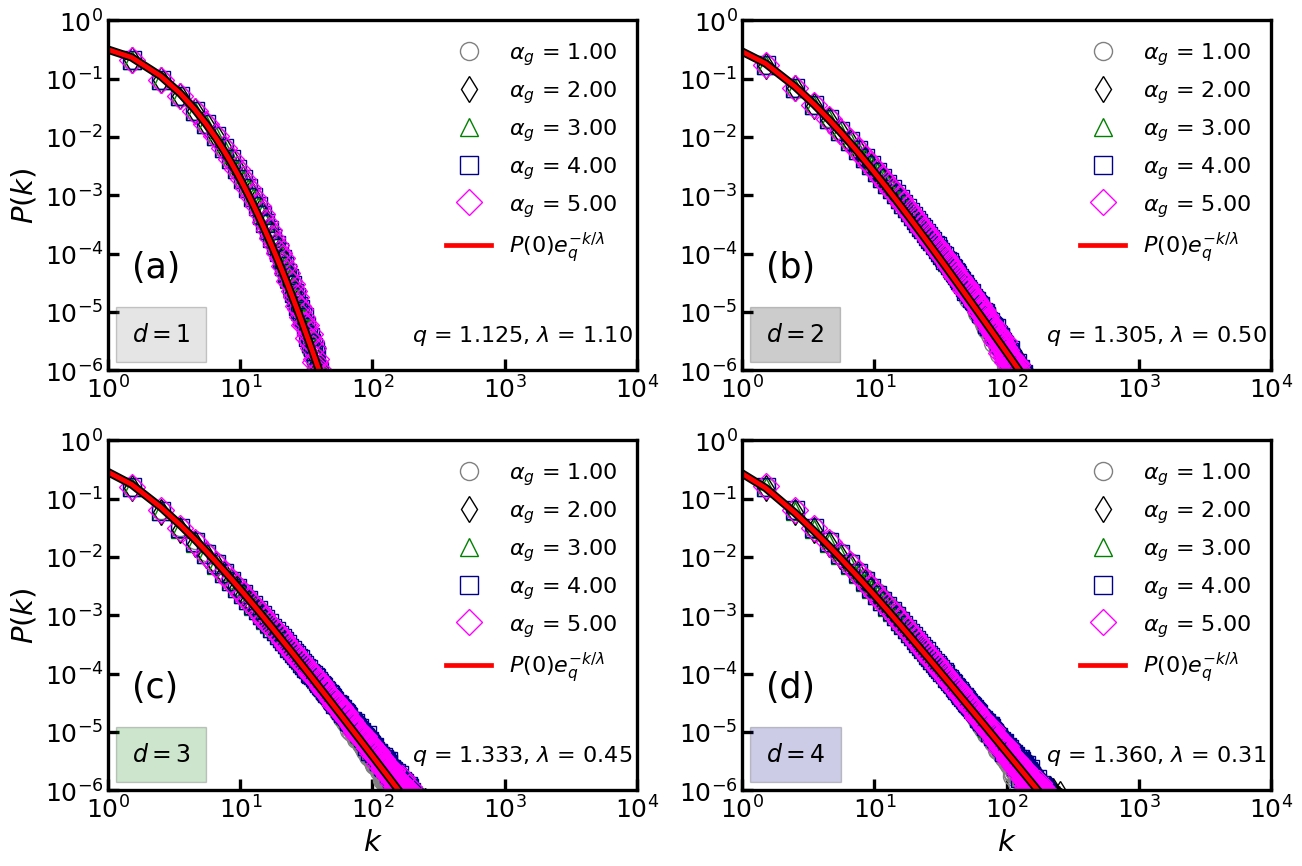

In [ ]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]

labels_1 = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]

markers = ["o","d","^","s","D"]
#markers = ["o","o","o","o","o"]
markersize = 13
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_g_v)):
     # Plot data
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i],markers[i],color=color[i],label=labels_1[i],markersize=markersize,markerfacecolor='none')
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i],markers[i],color=color[i],label=labels_1[i],markersize=markersize,markerfacecolor='none')
    ax[1, 0].plot(k_3d_g[i], pk_3d_g[i],markers[i],color=color[i],label=labels_1[i],markersize=markersize,markerfacecolor='none')
    ax[1, 1].plot(k_4d_g[i], pk_4d_g[i],markers[i],color=color[i],label=labels_1[i],markersize=markersize,markerfacecolor='none')


ax[0, 0].plot(k_1d_g[1],q_exp(k_1d_g[1], 1.125, 1.10),color="k",linewidth = 6.0)
ax[0, 1].plot(k_2d_g[1],q_exp(k_2d_g[1], 1.305, 0.50),color="k", linewidth = 6.0)
ax[1, 0].plot(k_3d_g[1],q_exp(k_3d_g[1], 1.333, 0.45),color="k", linewidth = 6.0)
ax[1, 1].plot(k_4d_g[1],q_exp(k_4d_g[1], 1.360, 0.31),color="k", linewidth = 6.0)

ax[0, 0].plot(k_1d_g[1],q_exp(k_1d_g[1], 1.125, 1.10),color="red",label=r"$P(0)e_q^{-k/\lambda}$", linewidth=3.4)
ax[0, 1].plot(k_2d_g[1],q_exp(k_2d_g[1], 1.305, 0.50),color="red",label=r"$P(0)e_q^{-k/\lambda}$", linewidth=3.4)
ax[1, 0].plot(k_3d_g[1],q_exp(k_3d_g[1], 1.333, 0.45),color="red",label=r"$P(0)e_q^{-k/\lambda}$", linewidth=3.4)
ax[1, 1].plot(k_4d_g[1],q_exp(k_4d_g[1], 1.360, 0.31),color="red",label=r"$P(0)e_q^{-k/\lambda}$", linewidth=3.4)

# Dimension Values
ax[0, 0].text(1.5, 10**(-5.5), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
ax[0, 1].text(1.5, 10**(-5.5), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
ax[1, 0].text(1.5, 10**(-5.5), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
ax[1, 1].text(1.5, 10**(-5.5), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})


ax[0, 0].text(1.5, 10**(-4.4), "(a)", style="normal" ,fontsize=25)
ax[0, 1].text(1.5, 10**(-4.4), "(b)", style="normal" ,fontsize=25)
ax[1, 0].text(1.5, 10**(-4.4), "(c)", style="normal" ,fontsize=25)
ax[1, 1].text(1.5, 10**(-4.4), "(d)", style="normal" ,fontsize=25)


ax[0, 0].text(10**2.3, 10**(-5.5), f'$q$ = {1.125:.3f}, $\\lambda$ = {1.10:.2f}', style="normal" ,fontsize=16)
ax[0, 1].text(10**2.3, 10**(-5.5), f'$q$ = {1.305:.3f}, $\\lambda$ = {0.50:.2f}', style="normal" ,fontsize=16)
ax[1, 0].text(10**2.3, 10**(-5.5), f'$q$ = {1.333:.3f}, $\\lambda$ = {0.45:.2f}', style="normal" ,fontsize=16)
ax[1, 1].text(10**2.3, 10**(-5.5), f'$q$ = {1.360:.3f}, $\\lambda$ = {0.31:.2f}', style="normal" ,fontsize=16)
# ax[1, 1].text(230.5, 10**(-5.5), f'$q$ = {round(q(2.0, 4),2)}, $\lambda$ = {round(1/eta(2.0, 4),2)}', style="normal" ,fontsize=16)

thickness_axes =  2.4
parts_of_graphic = ['top', 'bottom', 'left', 'right']
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([1,10**4])
        ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(k)$",size=21)
        ax[1, j].set_xlabel(r"$k$",size=21)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        for k in parts_of_graphic:
            ax[i, j].spines[k].set_linewidth(thickness_axes)
        ax[i,j].tick_params(which='major', width=thickness_axes,direction="in",length=8,labelsize=18)
#fig.suptitle(r'Distribuição de graus para múltiplos $\alpha_g$', fontsize=30)
plt.savefig("../../results/distributions/degree_alpha_g.pdf",dpi=300)
plt.show()

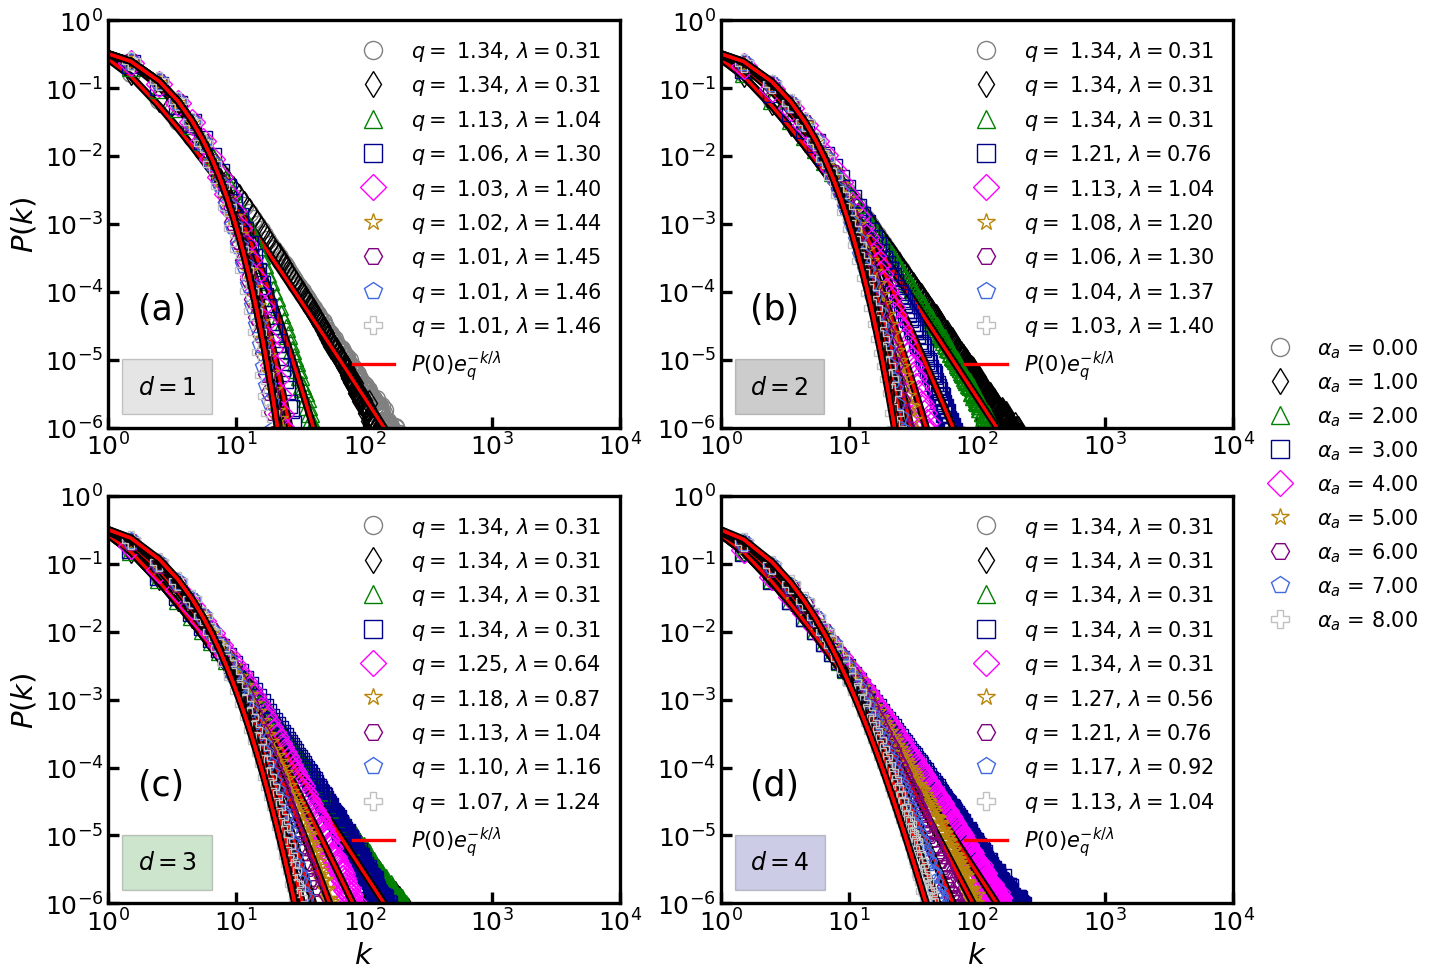

In [40]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod","purple","royalblue", "silver"]

markers = ["o","d","^","s","D","*","H","p","P"]

labels_global = [rf"$\alpha_a$ = {alpha_a_v[i]:.2f}" for i in range(len(alpha_a_v))]

markersize = 13
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_a_v)):
    Q_1d, B_1d = optimize_q_exp(k_1d_a[i], pk_1d_a[i], q_initial=q(alpha_a_v[i],1), b_initial=eta(alpha_a_v[i],1), delta_q=0.01, delta_b=0.01)
    Q_2d, B_2d = optimize_q_exp(k_2d_a[i], pk_2d_a[i], q_initial=q(alpha_a_v[i],2), b_initial=eta(alpha_a_v[i],2), delta_q=0.01, delta_b=0.01)
    Q_3d, B_3d = optimize_q_exp(k_3d_a[i], pk_3d_a[i], q_initial=q(alpha_a_v[i],3), b_initial=eta(alpha_a_v[i],3), delta_q=0.01, delta_b=0.01)
    Q_4d, B_4d = optimize_q_exp(k_4d_a[i], pk_4d_a[i], q_initial=q(alpha_a_v[i],4), b_initial=eta(alpha_a_v[i],4), delta_q=0.01, delta_b=0.01)
    
    # Plot data
    ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i],color=color[i],label=rf'$q =$ {Q_1d:.2f}, $\lambda = {B_1d:.2f}$',markersize=markersize,markerfacecolor='none')
    ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i],color=color[i],label=rf'$q =$ {Q_2d:.2f}, $\lambda = {B_2d:.2f}$',markersize=markersize,markerfacecolor='none')
    ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i],color=color[i],label=rf'$q =$ {Q_3d:.2f}, $\lambda = {B_3d:.2f}$',markersize=markersize,markerfacecolor='none')
    ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i],color=color[i],label=rf'$q =$ {Q_4d:.2f}, $\lambda = {B_4d:.2f}$',markersize=markersize,markerfacecolor='none')
    
    if(i != 0.0):
        ax[0, 0].plot(k_1d_a[i], q_exp(k_1d_a[i], Q_1d, B_1d), color='k', linewidth=5.4)
        ax[0, 1].plot(k_2d_a[i], q_exp(k_2d_a[i], Q_2d, B_2d), color='k', linewidth=5.4)
        ax[1, 0].plot(k_3d_a[i], q_exp(k_3d_a[i], Q_3d, B_3d), color='k', linewidth=5.4)
        ax[1, 1].plot(k_4d_a[i], q_exp(k_4d_a[i], Q_4d, B_4d), color='k', linewidth=5.4)

        ax[0, 0].plot(k_1d_a[i], q_exp(k_1d_a[i], Q_1d, B_1d), color='red', linewidth=2.4)
        ax[0, 1].plot(k_2d_a[i], q_exp(k_2d_a[i], Q_2d, B_2d), color='red', linewidth=2.4)
        ax[1, 0].plot(k_3d_a[i], q_exp(k_3d_a[i], Q_3d, B_3d), color='red', linewidth=2.4)
        ax[1, 1].plot(k_4d_a[i], q_exp(k_4d_a[i], Q_4d, B_4d), color='red', linewidth=2.4)

ax[0, 0].plot(k_1d_a[0],q_exp(k_1d_a[0], Q_1d, B_1d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
ax[0, 1].plot(k_2d_a[0],q_exp(k_2d_a[0], Q_2d, B_2d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
ax[1, 0].plot(k_3d_a[0],q_exp(k_3d_a[0], Q_3d, B_3d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)
ax[1, 1].plot(k_4d_a[0],q_exp(k_4d_a[0], Q_4d, B_4d), color='red', label = r"$P(0)e_q^{-k/\lambda}$", linewidth=2.4)

# Dimension Values
ax[0, 0].text(1.7, 10**(-5.5), f'$d = 1$', style="normal" ,fontsize=17, bbox={'facecolor': color[0], 'alpha': 0.2, 'pad': 11})
ax[0, 1].text(1.7, 10**(-5.5), f'$d = 2$', style="normal" ,fontsize=17, bbox={'facecolor': color[1], 'alpha': 0.2, 'pad': 11})
ax[1, 0].text(1.7, 10**(-5.5), f'$d = 3$', style="normal" ,fontsize=17, bbox={'facecolor': color[2], 'alpha': 0.2, 'pad': 11})
ax[1, 1].text(1.7, 10**(-5.5), f'$d = 4$', style="normal" ,fontsize=17, bbox={'facecolor': color[3], 'alpha': 0.2, 'pad': 11})

ax[0, 0].text(1.7, 10**(-4.4), "(a)", style="normal" ,fontsize=25)
ax[0, 1].text(1.7, 10**(-4.4), "(b)", style="normal" ,fontsize=25)
ax[1, 0].text(1.7, 10**(-4.4), "(c)", style="normal" ,fontsize=25)
ax[1, 1].text(1.7, 10**(-4.4), "(d)", style="normal" ,fontsize=25)
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_a_v))]

# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=15, frameon=False)

parts_of_graphic = ['top', 'bottom', 'left', 'right']

for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim([1,10**4])
        ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        ax[i, j].legend(prop={"size":15},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(k)$",size=21)
        ax[1, j].set_xlabel(r"$k$",size=21)
        #ax[i, j].tick_params('both', labelsize=21)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        for k in parts_of_graphic:
            ax[i, j].spines[k].set_linewidth(thickness_axes)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        ax[i,j].tick_params(which='major', width=thickness_axes,direction="in",length=8,labelsize=18)
#fig.suptitle(r'Distribuição de graus para múltiplos $\alpha_a$', fontsize=30)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/degree_alpha_a.pdf",dpi=300)
plt.show()

In [4]:
k_1d_g, pk_1d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_2d_g, pk_2d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_3d_g, pk_3d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]
k_4d_g, pk_4d_g = [[] for _ in range(len(alpha_g_v))],[[] for _ in range(len(alpha_g_v))]

k_1d_a, pk_1d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_2d_a, pk_2d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_3d_a, pk_3d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]
k_4d_a, pk_4d_a = [[] for _ in range(len(alpha_a_v))],[[] for _ in range(len(alpha_a_v))]

In [5]:
for i in range(len(alpha_g_v)):
    df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')
    df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_f:.2f}_alpha_g_{alpha_g_v[i]:.2f}/distances_distribution_log.csv", delimiter=' ')

    k_1d_g[i], pk_1d_g[i] = df_1d["ds"], df_1d["pds"]
    k_2d_g[i], pk_2d_g[i] = df_2d["ds"], df_2d["pds"]
    k_3d_g[i], pk_3d_g[i] = df_3d["ds"], df_3d["pds"]
    k_4d_g[i], pk_4d_g[i] = df_4d["ds"], df_4d["pds"]

In [6]:
for i in range(len(alpha_a_v)):
        df_1d = pd.read_csv(f"../../data/N_{N}/dim_1/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_2d = pd.read_csv(f"../../data/N_{N}/dim_2/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_3d = pd.read_csv(f"../../data/N_{N}/dim_3/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')
        df_4d = pd.read_csv(f"../../data/N_{N}/dim_4/alpha_a_{alpha_a_v[i]:.2f}_alpha_g_{alpha_g_f:.2f}/distances_distribution_log.csv", delimiter=' ')

        k_1d_a[i], pk_1d_a[i] = df_1d["ds"], df_1d["pds"]
        k_2d_a[i], pk_2d_a[i] = df_2d["ds"], df_2d["pds"]
        k_3d_a[i], pk_3d_a[i] = df_3d["ds"], df_3d["pds"]
        k_4d_a[i], pk_4d_a[i] = df_4d["ds"], df_4d["pds"]

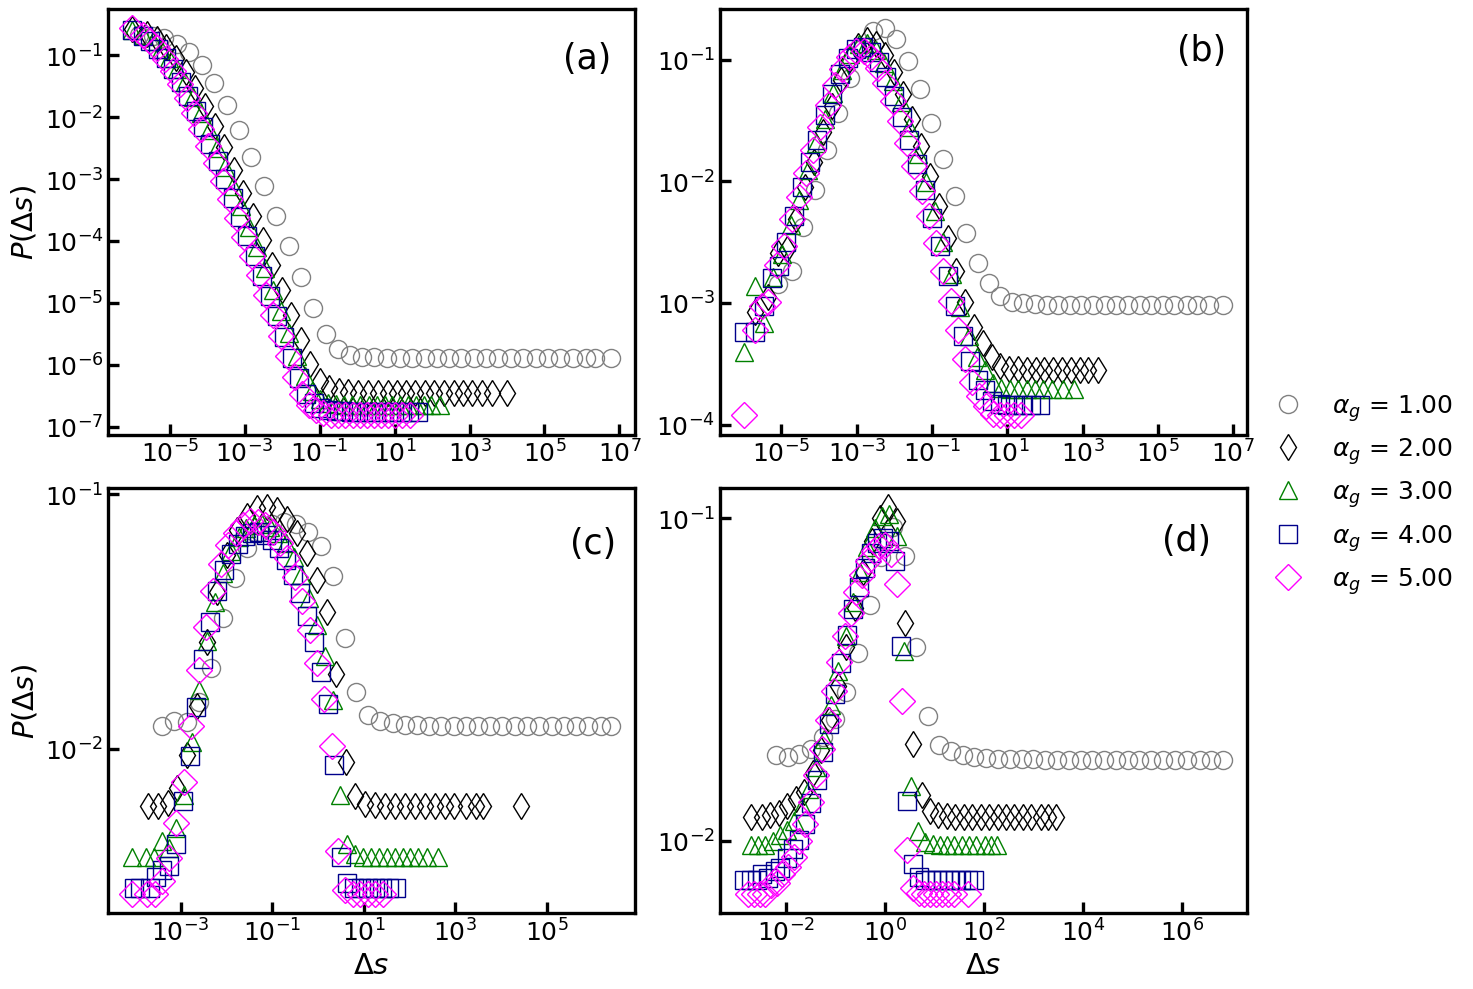

In [70]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]
markers = ["o","d","^","s","D"]
#markers = ["o","o","o","o","o"]
labels_global = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]
markersize = 13
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_g_v)):
     # Plot data
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')
    ax[1, 0].plot(k_3d_g[i], pk_3d_g[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')
    ax[1, 1].plot(k_4d_g[i], pk_4d_g[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')

thickness_axes =  2.4
parts_of_graphic = ['top', 'bottom', 'left', 'right']
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_g_v))]
# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=18, frameon=False)

ax[0, 0].text(10**(5.5), 10**(-1.2), "(a)", style="normal" ,fontsize=25)
ax[0, 1].text(10**(5.5), 10**(-1.0), "(b)", style="normal" ,fontsize=25)
ax[1, 0].text(10**5.5, 10**(-1.23), "(c)", style="normal" ,fontsize=25)
ax[1, 1].text(10**5.6, 10**(-1.1), "(d)", style="normal" ,fontsize=25)

for i in range(2):
    for j in range(2):
        #ax[i, j].set_xlim([1,10**4])
        #ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$",size=21)
        ax[1, j].set_xlabel(r"$\Delta s$",size=21)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        for k in parts_of_graphic:
            ax[i, j].spines[k].set_linewidth(thickness_axes)
        ax[i,j].tick_params(which='major', width=thickness_axes,direction="in",length=8,labelsize=18)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_g_N100000.pdf")
plt.show()

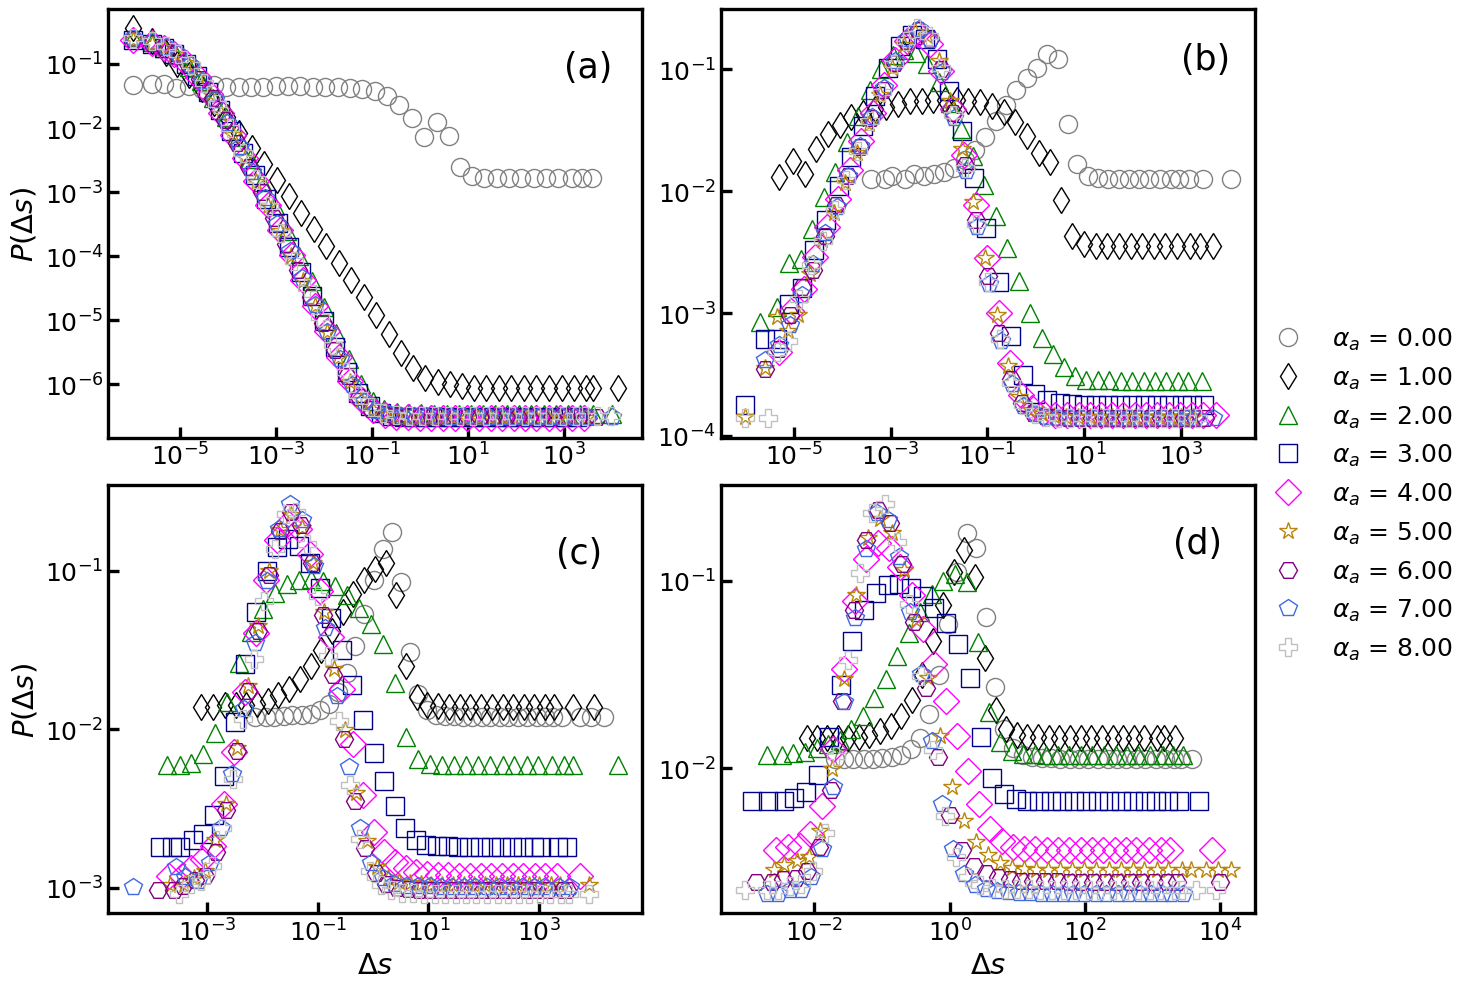

In [75]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod","purple","royalblue", "silver"]

markers = ["o","d","^","s","D","*","H","p","P"]
labels_global = [rf"$\alpha_a$ = {alpha_a_v[i]:.2f}" for i in range(len(alpha_a_v))]
#markers = ["o","o","o","o","o"]
labels_1 = [rf"$\alpha_a$ = {i:.2f}" for i in alpha_a_v]
markersize = 13
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_a_v)):
     # Plot data
    ax[0, 0].plot(k_1d_a[i], pk_1d_a[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')
    ax[0, 1].plot(k_2d_a[i], pk_2d_a[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')
    ax[1, 0].plot(k_3d_a[i], pk_3d_a[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')
    ax[1, 1].plot(k_4d_a[i], pk_4d_a[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')

thickness_axes =  2.4
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_a_v))]
# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=18, frameon=False)

ax[0, 0].text(10**(3), 10**(-1.2), "(a)", style="normal" ,fontsize=25)
ax[0, 1].text(10**(3), 10**(-1.0), "(b)", style="normal" ,fontsize=25)
ax[1, 0].text(10**3.3, 10**(-.95), "(c)", style="normal" ,fontsize=25)
ax[1, 1].text(10**3.3, 10**(-.85), "(d)", style="normal" ,fontsize=25)

parts_of_graphic = ['top', 'bottom', 'left', 'right']
for i in range(2):
    for j in range(2):
        #ax[i, j].set_xlim([1,10**4])
        #ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$",size=21)
        ax[1, j].set_xlabel(r"$\Delta s$",size=21)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        for k in parts_of_graphic:
            ax[i, j].spines[k].set_linewidth(thickness_axes)
        ax[i,j].tick_params(which='major', width=thickness_axes,direction="in",length=8,labelsize=18)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("../../results/distributions/distances_alpha_a_N100000.pdf")
plt.show()

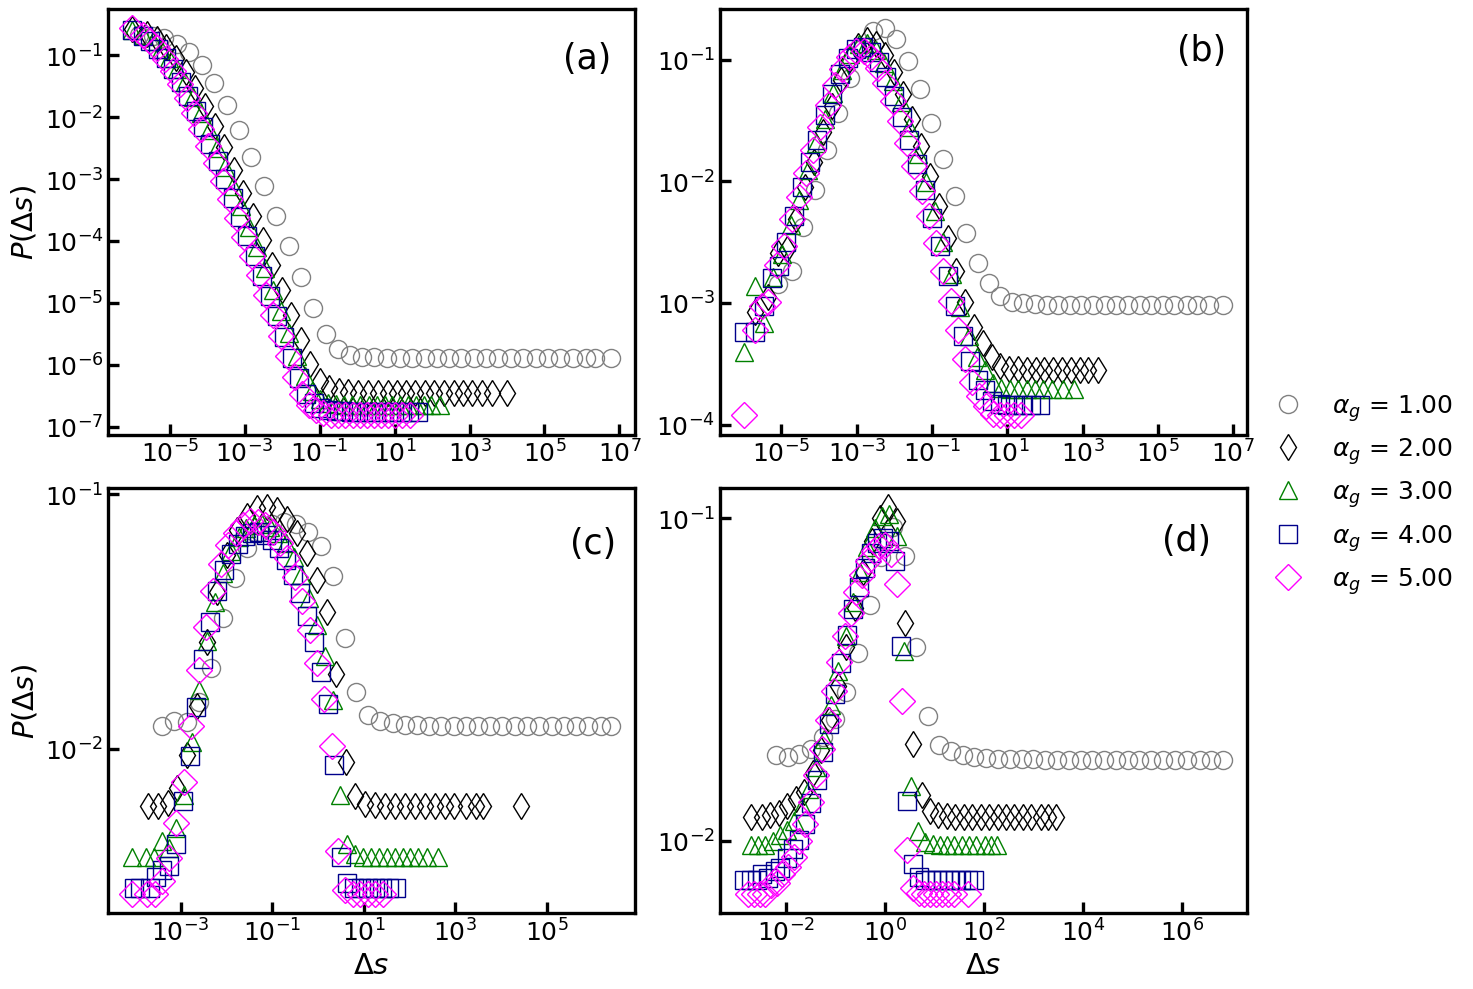

In [15]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]
markers = ["o","d","^","s","D"]
#markers = ["o","o","o","o","o"]
labels_global = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]
markersize = 13
fig, ax = plt.subplots(2, 2,figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
for i in range(len(alpha_g_v)):
    # Plot data
    ax[0, 0].plot(k_1d_g[i], pk_1d_g[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')
    ax[0, 1].plot(k_2d_g[i], pk_2d_g[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')
    ax[1, 0].plot(k_3d_g[i], pk_3d_g[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')
    ax[1, 1].plot(k_4d_g[i], pk_4d_g[i],markers[i],color=color[i],markersize=markersize,markerfacecolor='none')

thickness_axes =  2.4
parts_of_graphic = ['top', 'bottom', 'left', 'right']
# Criando proxies para a legenda global (α_a)
proxy_handles = [plt.Line2D([], [], color=color[i], marker=markers[i], linestyle='None', markersize=markersize, markerfacecolor='none') for i in range(len(alpha_g_v))]
# Adicionando legenda compartilhada global na lateral direita
fig.legend(proxy_handles, labels_global, loc="center left", bbox_to_anchor=(0.83, 0.5), fontsize=18, frameon=False)

ax[0, 0].text(10**(5.5), 10**(-1.2), "(a)", style="normal" ,fontsize=25)
ax[0, 1].text(10**(5.5), 10**(-1.0), "(b)", style="normal" ,fontsize=25)
ax[1, 0].text(10**5.5, 10**(-1.23), "(c)", style="normal" ,fontsize=25)
ax[1, 1].text(10**5.6, 10**(-1.1), "(d)", style="normal" ,fontsize=25)

for i in range(2):
    for j in range(2):
        #ax[i, j].set_xlim([1,10**4])
        #ax[i, j].set_ylim([10**(-6),1])
        
        ax[i, j].set_yscale('log')
        ax[i, j].set_xscale('log')
        #ax[i, j].legend(prop={"size":16},fancybox=True,framealpha=0.0)
        ax[i, 0].set_ylabel(r"$P(\Delta s)$",size=21)
        ax[1, j].set_xlabel(r"$\Delta s$",size=21)
        ax[i, j].xaxis.set_minor_locator(plt.NullLocator())
        ax[i, j].yaxis.set_minor_locator(plt.NullLocator())
        #ax[i, j].tick_params('both', labelsize=21)
        #ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
        for k in parts_of_graphic:
            ax[i, j].spines[k].set_linewidth(thickness_axes)
        ax[i,j].tick_params(which='major', width=thickness_axes,direction="in",length=8,labelsize=18)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig("distances_alpha_g_N100000_filt.pdf")
plt.show()

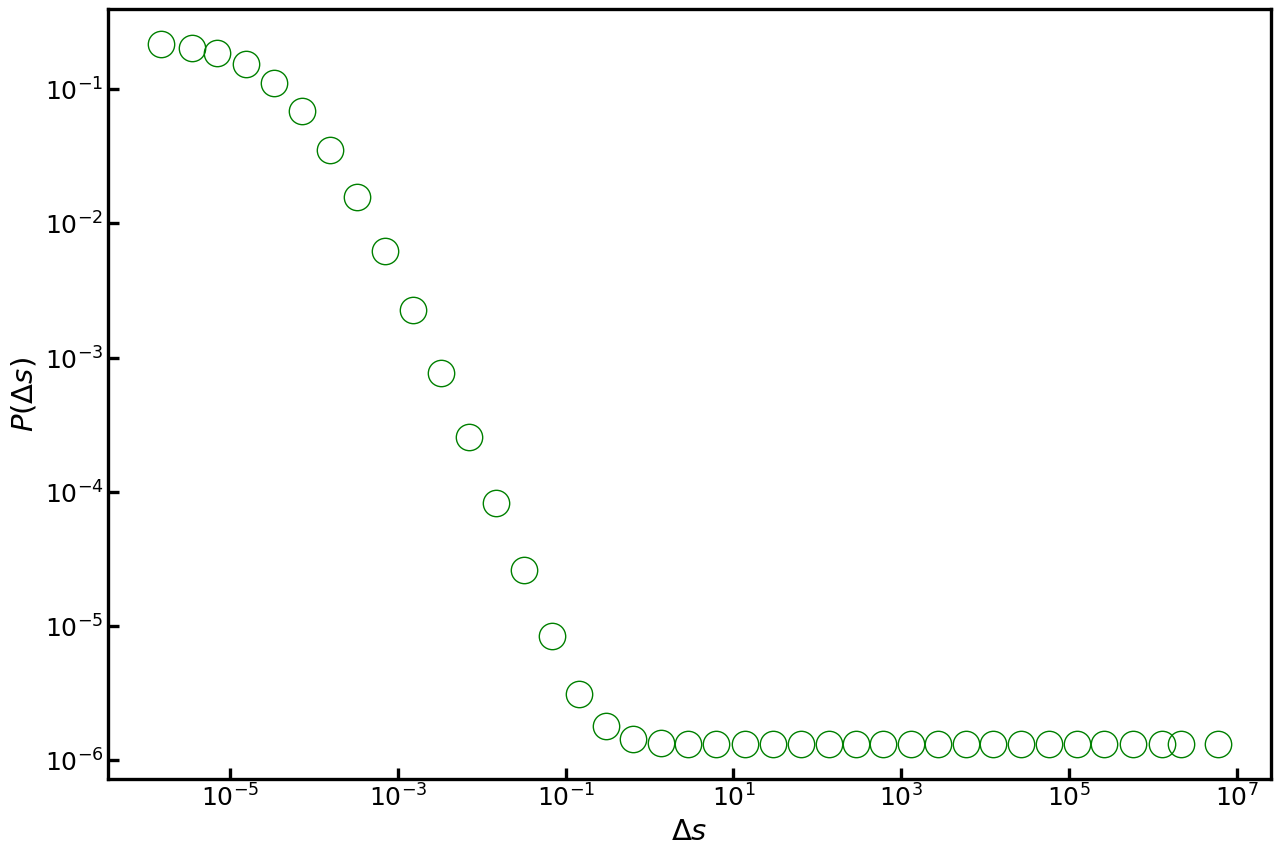

In [20]:
color = ["#808080","black",'#008000',"#00008B","magenta","darkgoldenrod"]
markers = ["o","d","^","s","D"]
#markers = ["o","o","o","o","o"]
labels_global = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]
markersize = 19
fig, ax = plt.subplots(figsize=(15,10))
#fig.suptitle(r'Distribuição de graus da rede para múltiplos $\alpha_g$', fontsize=20)
ax.plot(k_1d_g[0], pk_1d_g[0],markers[0],color=color[2],markersize=markersize,markerfacecolor='none')
ax.set_yscale('log')
ax.set_xscale('log')
#ax.legend(prop={"size":16},fancybox=True,framealpha=0.0)
ax.set_ylabel(r"$P(\Delta s)$",size=21)
ax.set_xlabel(r"$\Delta s$",size=21)
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_locator(plt.NullLocator())
#ax.tick_params('both', labelsize=21)
#ax[i,j].tick_params(which='minor', width=1.4,length=4,labelsize=18)
for k in parts_of_graphic:
    ax.spines[k].set_linewidth(thickness_axes)
ax.tick_params(which='major', width=thickness_axes,direction="in",length=8,labelsize=18)
plt.show()

/home/junior/.local/lib/python3.12/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


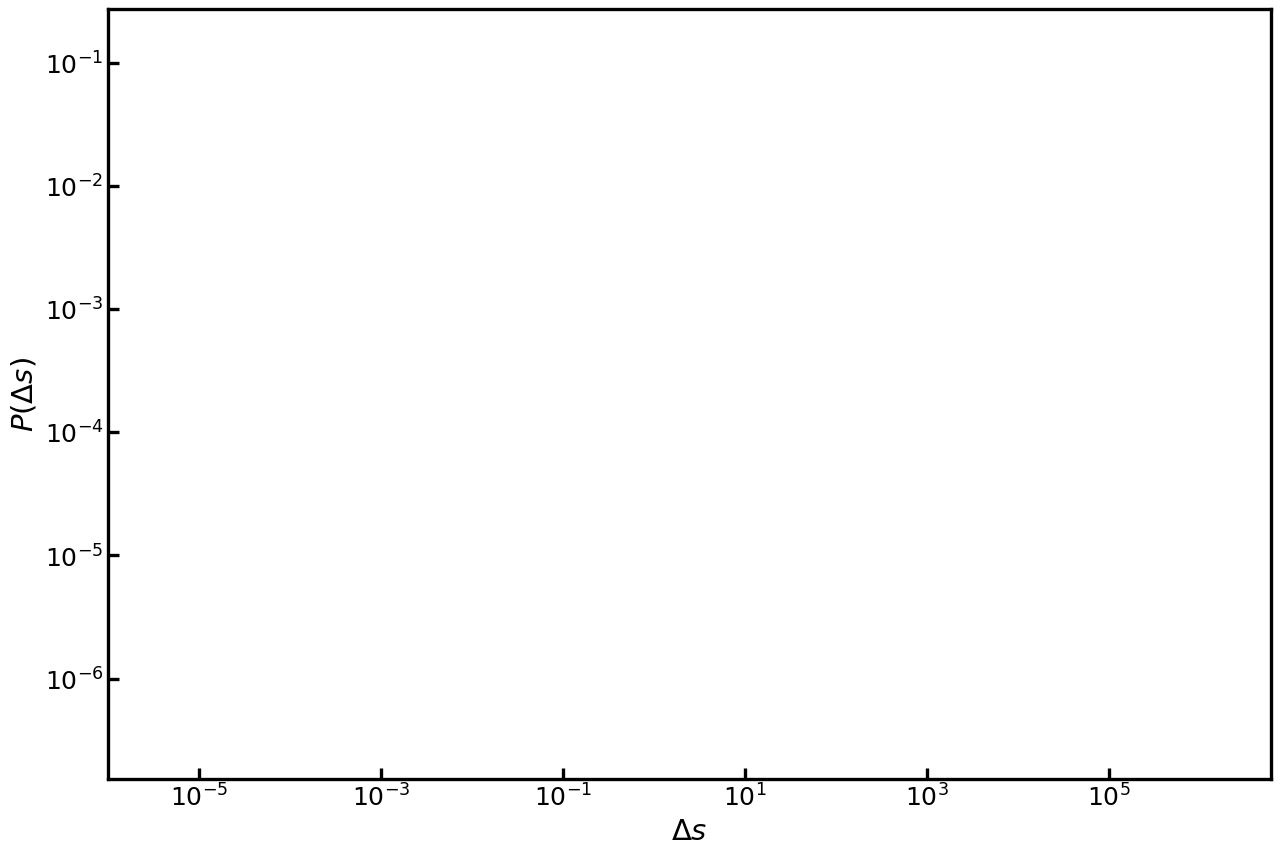

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Configuração de cores e marcadores
color = ["#808080", "black", '#008000', "#00008B", "magenta", "darkgoldenrod"]
markers = ["o", "d", "^", "s", "D"]
labels_global = [rf"$\alpha_g$ = {i:.2f}" for i in alpha_g_v]
markersize = 13

# Criando a figura e o eixo único
fig, ax = plt.subplots(figsize=(15, 10))

# Configuração inicial dos eixos
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel(r"$P(\Delta s)$", size=21)
ax.set_xlabel(r"$\Delta s$", size=21)
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.yaxis.set_minor_locator(plt.NullLocator())

thickness_axes = 2.4
parts_of_graphic = ['top', 'bottom', 'left', 'right']
for k in parts_of_graphic:
    ax.spines[k].set_linewidth(thickness_axes)
ax.tick_params(which='major', width=thickness_axes, direction="in", length=8, labelsize=18)

# Criando objeto de plot (inicialmente vazio)
line, = ax.plot([], [], markers[0], color=color[2], markersize=markersize, markerfacecolor='none')

# Definição dos limites do gráfico com base nos dados disponíveis
ax.set_xlim([min(min(k) for k in k_1d_g), max(max(k) for k in k_1d_g)])
ax.set_ylim([min(min(pk) for pk in pk_1d_g), max(max(pk) for pk in pk_1d_g)])

# Função de atualização da animação
def update(i):
    """ Atualiza o gráfico para o índice i. """
    line.set_data(k_1d_g[i], pk_1d_g[i])
    line.set_marker(markers[i % len(markers)])  # Alterna marcadores
    line.set_color(color[i % len(color)])  # Alterna cores
    ax.set_title(labels_global[i], fontsize=22)  # Atualiza título
    return line,

# Criando a animação e garantindo que ela não seja deletada
ani = animation.FuncAnimation(fig, update, frames=len(alpha_g_v), interval=500, repeat=True)

# Garantindo que a animação não seja deletada antes da exibição
plt.show()

# Evita a remoção automática da animação
plt.rcParams['animation.html'] = 'jshtml'
ani  # Mantém referência ativa
